# Machine learning with raw frequencies

This notebook will start with the applying Naive Bayes on the raw frequencies of the adjectives, adverbs and negations of our training set. Then we will use the tf-idf weighting instead of the raw frequencies count. After this we will create co-occurences and use it to train a Naive Bayes model.

In [2]:
import pickle
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn import naive_bayes, metrics
from itertools import chain
from math import log
from nltk import BigramAssocMeasures

#Importing our train and test set
with open('test_dicts.txt', 'rb') as file:
    test_lemmedreviews = pickle.load(file)
    
with open('training_dicts.txt', 'rb') as file:
    train_lemmedreviews = pickle.load(file)

In [2]:
#Getting all adverbs, adjectives and negations from our training set
candidate_features = Counter()

for p in range(1, 6):
    for rev in train_lemmedreviews[p]:
        for w in rev:
            if w.split("-")[-1] in ["ADJ", "ADV", "NEGATION"]:
                candidate_features[w] += 1

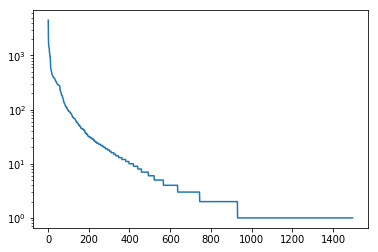

In [3]:
#Plotting the frequencies
x = np.arange(1, len(candidate_features) + 1)
y = np.array([v for _, v in candidate_features.most_common()])

plt.plot(x, y)
plt.yscale('log') 
plt.show()

In [4]:
#Selecting all words that occur more than nine times
features = dict()

for idx, (f, v) in enumerate(candidate_features.most_common()):
    if v == 9:
    #    print(idx, f, v)
        break

    features[f] = idx

## Normal weighting
Here a normal weight will be given to the frequencies

In [5]:
#Creating the matrix that contains the frequencies of the features per review
fMat = np.zeros((sum([len(v) for v in train_lemmedreviews.values()]), len(features)))

#Creating the labels
labelsVec = np.zeros((sum([len(v) for v in train_lemmedreviews.values()])))

docId = 0
for score in range(1, 6):
    for rev in train_lemmedreviews[score]:
        labelsVec[docId] = score
        
        for word in rev:
            if word in features:
                fMat[docId, features[word]] += 1

        docId += 1
        
print(fMat, labelsVec)

[[2. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]] [1. 1. 1. ... 5. 5. 5.]


In [6]:
#Training the Naive bayes
clf = naive_bayes.MultinomialNB()
clf.fit(fMat, labelsVec)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [7]:
#Creating the matrix with the same features for testing
testMat = np.zeros((sum([len(v) for v in test_lemmedreviews.values()]), len(features)))

#Creating the golden standard to say something about accuracy
goldStandard = np.zeros((sum([len(v) for v in test_lemmedreviews.values()])))

docId = 0
for score in range(1, 6):
    for rev in test_lemmedreviews[score]:
        goldStandard[docId] = score

        for word in rev:
            if word in features:
                testMat[docId, features[word]] += 1

        docId += 1

In [8]:
#Using the Naive Bayes to predict the goldStandard using the test matrix
predicted = clf.predict(testMat)

In [9]:
# accuracy
print("accuracy:", metrics.accuracy_score(predicted, goldStandard))

# precision, recall and f-measure
print("precision:", metrics.precision_score(predicted, goldStandard, average='macro'))
print("recall:", metrics.recall_score(predicted, goldStandard, average='macro'))
print("f1-measure:", metrics.f1_score(predicted, goldStandard, average='macro'))

accuracy: 0.6545
precision: 0.36636764973559377
recall: 0.4883243165902673
f1-measure: 0.38717166943275044


## Machine learning with tf-idf weighting
Instead of a normal weighting, tf-idf will be used

In [10]:
#Creating the matrix with the same features for testing
fMat = np.zeros((sum([len(v) for v in train_lemmedreviews.values()]), len(features)))

#Creating the labels
labelsVec = np.zeros((sum([len(v) for v in train_lemmedreviews.values()])))


docId = 0
for score in range(1, 6):
    for rev in train_lemmedreviews[score]:
        labelsVec[docId] = score
        
        for word in rev:
            if word in features:
                fMat[docId, features[word]] += 1

        docId += 1
        

#Applying tf-idf weighting
D=(sum([len(v) for v in train_lemmedreviews.values()]))
for column in range(len(features)): 
    Dt = len(np.where(fMat[:,column] > 0)[0])   
    fMat[:, column] = fMat[:, column] * np.log(D/Dt)    

In [11]:
#Creating another Naive Bayes model
clf = naive_bayes.MultinomialNB()
clf.fit(fMat, labelsVec)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [12]:
#Creating the matrix with the same features for testing
testMat = np.zeros((sum([len(v) for v in test_lemmedreviews.values()]), len(features)))

#Creating the golden standard to say something about accuracy
goldStandard = np.zeros((sum([len(v) for v in test_lemmedreviews.values()])))

docId = 0
for score in range(1, 6):
    for rev in test_lemmedreviews[score]:
        goldStandard[docId] = score

        for word in rev:
            if word in features:
                testMat[docId, features[word]] += 1

        docId += 1

#Creating the tf-idf weighting
D=sum([len(v) for v in test_lemmedreviews.values()])
for column in range(len(features)): 
    Dt = len(np.where(testMat[:,column] > 0)[0])
    if Dt > 0:  #needs to account for a word not occuring in any document
        testMat[:, column] = testMat[:, column] * np.log(D/Dt)

In [13]:
#Creating the predictions
predicted = clf.predict(testMat)

In [14]:
# accuracy
print("accuracy:", metrics.accuracy_score(predicted, goldStandard))

# precision, recall and f-measure
print("precision:", metrics.precision_score(predicted, goldStandard, average='macro'))
print("recall:", metrics.recall_score(predicted, goldStandard, average='macro'))
print("f1-measure:", metrics.f1_score(predicted, goldStandard, average='macro'))

accuracy: 0.57
precision: 0.4397407802023789
recall: 0.4058294395110238
f1-measure: 0.41862555920643824


# Machine Learning with co-occurences

In [3]:
#Creating the co-occurences
span = 3
cooccs_candidate_feature = Counter()

for p in range(1, 6):
    for sentence in train_lemmedreviews[p]:
        for i,w in enumerate(sentence):
            #check all co-occurring words within a 3 word span 
            span_range = list(range(max(i- span, 0), i)) 
            span_range.extend(range(i+1, min(i + span + 1, len(sentence)))) 
            for cw in [sentence[idx] for idx in span_range]:
                if cw != w and (cw, w) not in cooccs_candidate_feature:
                    cooccs_candidate_feature[(w, cw)] += 1


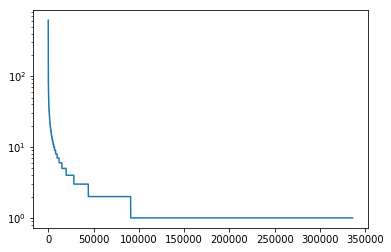

In [4]:
#Creating a plot to visualize the frequencies
x = np.arange(1, len(cooccs_candidate_feature) + 1)
y = np.array([v for _, v in cooccs_candidate_feature.most_common()])

plt.plot(x, y)
plt.yscale('log') 
plt.show()

In [5]:
#Selecting all co-occurences that appear 10 or more times. These will become the features
cooccs_features = dict()

for idx, (f, v) in enumerate(cooccs_candidate_feature.most_common()):
    if v == 9:
    #    print(idx, f, v)
        break

    cooccs_features[f] = idx

In [13]:
#Creating the matrix with features per review
fMat = np.zeros((sum([len(v) for v in train_lemmedreviews.values()]), len(cooccs_features)))
#Creating the labels
labelsVec = np.zeros((sum([len(v) for v in train_lemmedreviews.values()])))

docId = 0
for score in range(1, 6):
    for rev in train_lemmedreviews[score]:
        labelsVec[docId] = score       
        span = 3
        cooccs_rev = Counter()

        #Makingt he co-occurences for one review
        for i,w in enumerate(rev):
            #check all co-occurring words within a 3 word span 
            span_range = list(range(max(i- span, 0), i)) 
            span_range.extend(range(i+1, min(i + span + 1, len(rev)))) 
            for cw in [rev[idx] for idx in span_range]:
                if cw != w and (cw, w) not in cooccs_rev:
                    cooccs_rev[(w, cw)] += 1
        
        #Adding the frequencies of the co-occurences to the feature matrix
        for cooccs in list(cooccs_rev.keys()):
            if cooccs in cooccs_features:
                fMat[docId, cooccs_features[cooccs]] = cooccs_rev[cooccs]

        docId += 1
        
print(fMat, labelsVec)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [1. 1. 1. ... 5. 5. 5.]


In [14]:
#Creating a model
clf = naive_bayes.MultinomialNB()
clf.fit(fMat, labelsVec)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [15]:
#Creating a matrix for the features per review for testing
testMat = np.zeros((sum([len(v) for v in test_lemmedreviews.values()]), len(cooccs_features)))

#Creating the gold standard to compare the result of the test set to
goldStandard = np.zeros((sum([len(v) for v in test_lemmedreviews.values()])))

docId = 0
for score in range(1, 6):
    for rev in test_lemmedreviews[score]:
        goldStandard[docId] = score
        
        span = 3
        cooccs_rev = Counter()

        for i,w in enumerate(rev):
            #check all co-occurring words within a 3 word span 
            span_range = list(range(max(i- span, 0), i)) 
            span_range.extend(range(i+1, min(i + span + 1, len(rev)))) 
            for cw in [rev[idx] for idx in span_range]:
                if cw != w and (cw, w) not in cooccs_rev:
                    cooccs_rev[(w, cw)] += 1
        
        
        for cooccs in list(cooccs_rev.keys()):
            if cooccs in cooccs_features:
                testMat[docId, cooccs_features[cooccs]] = cooccs_rev[cooccs]

        docId += 1
        
print(testMat, goldStandard)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [1. 1. 1. ... 5. 5. 5.]


In [18]:
#Creating the preciction
predicted = clf.predict(testMat)

In [19]:
# accuracy
print("accuracy:", metrics.accuracy_score(predicted, goldStandard))

# precision, recall and f-measure
print("precision:", metrics.precision_score(predicted, goldStandard, average='macro'))
print("recall:", metrics.recall_score(predicted, goldStandard, average='macro'))
print("f1-measure:", metrics.f1_score(predicted, goldStandard, average='macro'))

accuracy: 0.7745
precision: 0.6590395657341416
recall: 0.7085369041942501
f1-measure: 0.6814324747293516
